# Install package

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)




Sat Dec 17 00:11:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# run this cell if you use google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Efficient Reinforcement Learning Through Trajectory Generation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gym
import tensorflow as tf
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import copy
from tensorflow.keras import layers
from tensorflow import keras
import time
import cvxpy as cp
import pickle
import scipy

# Environment Setup

In [ ]:
class DynSystem(gym.Env):
    def  __init__(self, Matrix_A,Matrix_B, Matrix_C, dim_state,dim_action, dim_observe, Penalty_action):
        self.Matrix_A = Matrix_A.astype(np.float32)
        self.Matrix_B = Matrix_B.astype(np.float32)
        self.Matrix_C = Matrix_C.astype(np.float32)
        self.sigma_e = 0.5
        self.dim_action = dim_action
        self.dim_state = dim_state
        self.dim_observe = dim_observe
        self.state=[]
        self.delta_t = 1
        self.Penalty_action=np.float32(Penalty_action)
              
    def step(self, action):
        # integrate the state transition dynamics

        self.state=(self.state@(self.Matrix_A.T)+action@(self.Matrix_B.T)).copy()
        return self.state
    
    def set_state(self, state_input):
        self.state=state_input

    def reset(self):
        self.state = np.random.uniform(-1,1,(1,self.dim_action)).astype(np.float32)

        return self.state



### initialize the variables and system matrices





In [ ]:
Matrix_A = np.array([[1.178, 0.001, 0.511, -0.403],
                     [-0.051, 0.661, -0.011, 0.061],
                     [0.076, 0.335, 0.560, 0.382],
                     [0, 0.335, 0.089, 0.849]])
Matrix_B = np.array([[0.004, -0.087],
                     [0.467, 0.001],
                     [0.213, -0.235],
                     [0.213, -0.016]])

In [ ]:
dim_state =  np.shape(Matrix_A)[0]
dim_action =  np.shape(Matrix_B)[1]
dim_observe =  4
Matrix_C = np.identity(4)
Penalty_action=0.1

env = DynSystem(Matrix_A,Matrix_B, Matrix_C, dim_state,dim_action, dim_observe, Penalty_action)


## Init Simulation

In [ ]:
#linear droop control
def Action_linear(state,linear_coff,env):
    # action=(env.V_ref.T-state@env.select_V)*linear_coff
    action_nonconstrain = state@(linear_coff.T)
    # print(action_nonconstrain)
    # action=env.max_action-tf.nn.relu(env.max_action-action_nonconstrain)+tf.nn.relu(-env.max_action-action_nonconstrain)
    return action_nonconstrain


In [ ]:

linear_coff= np.array([[0.7610, -1.1363, 1.6945, -1.8123],
                       [3.5351, 0.4827, 3.3014, -2.6215]])
action_units=dim_action

In [ ]:
linear_coff0= np.array([[0.0639, -0.7069, -0.1572, -0.6710],
                       [2.1481, 0.0875, 1.4899, -0.9805]])

s [[-0.05051397 -0.0778792   0.02574476 -0.09865574]]


Text(0, 0.5, 'V (p.u.)')

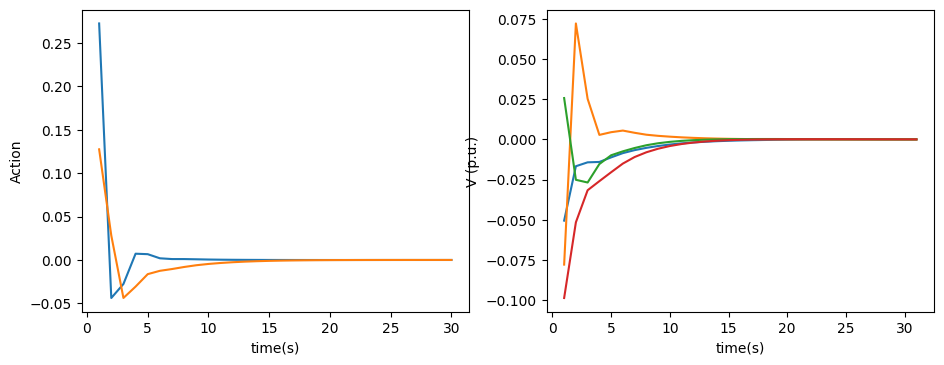

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[] 

init_state=np.random.uniform(-0.1,0.1,(1, dim_state))
# s_concate.copy()
s=init_state.copy()
env.set_state(s)
SimulationLength=30
Record_u_Linear=[]
Record_q_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
for i in range(SimulationLength):
    u=np.squeeze(Action_linear(s,linear_coff,env))
    # print(u)
    next_s= s@(Matrix_A.T) + u@(Matrix_B.T)
    # print('s',next_s)
    # env.step(u)
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_u_Linear.append(u.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
plt.figure(figsize=(11,4), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord


plt.subplot(1,2,1)

plt.plot(TimeRecord,Record_u_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action')

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(1,2,2)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


# Policy gradient

### action

In [ ]:
class Linear(tf.keras.Model):

    def __init__(self, units, action_units,env,batchsize):
        super(Linear, self).__init__()
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units   
        self.dim_state = env.dim_state 
        self.dim_action = env.dim_action 
        self.dim_observe = env.dim_observe 
        self.batchsize = batchsize

############# linear feedback controller

        self.k_node_p =  self.add_weight(
            shape=(self.dim_action, self.dim_observe),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.1),
            trainable=True,
            name='k_node_p')

        

    def call(self, prev_state):
        action_nonconstrain0_node_p =K.dot(prev_state, tf.transpose(self.k_node_p))
        return action_nonconstrain0_node_p




### policy gradient

In [ ]:
class Policy_gradient(tf.keras.Model):
    def __init__(self, units, action_units, env,batchsize, batchsize_test, **kwargs):
        super(Policy_gradient, self).__init__()
        # self.action_units=action_units
        self.sigma_e=env.sigma_e
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units    
        self.batchsize = batchsize
        self.batchsize_test = batchsize_test
        self.Matrix_A = tf.constant(env.Matrix_A,dtype = tf.float32)
        self.Matrix_B = tf.constant(env.Matrix_B,dtype = tf.float32)
        self.Matrix_C = tf.constant(env.Matrix_C,dtype = tf.float32)


    def Sample(self, T, initial_state, Noise_batch):
        Batch_num=self.batchsize
        prev_state=tf.constant(initial_state,dtype=tf.float32)
        # observance = prev_state@tf.transpose(self.Matrix_C)
        reward_record=np.zeros(Batch_num)
        Trajectory_record=[]
        Action_record=[]
        for i in range(0,T):
            observance =  prev_state@tf.transpose(self.Matrix_C)
            Trajectory_record.append(observance)
            observe_action = ChooseAction_OuterNoise( observance,env, Noise_batch[i])
            Action_record.append(observe_action)
            reward_record+= (env.Penalty_action*K.sum(K.abs(observe_action),axis=1)\
                            + K.sum(K.abs(observance),axis=1))   
                       
        # integrate the state transition dynamics
            new_state = K.dot(prev_state, tf.transpose(self.Matrix_A)) + K.dot(observe_action, tf.transpose(self.Matrix_B))
            prev_state = new_state

        return Trajectory_record,Action_record,reward_record

    def Sample_One(self, T, initial_state, Noise_batch):
        Batch_num=self.batchsize
        prev_state=tf.constant(initial_state,dtype=tf.float32)
        observance = prev_state@tf.transpose(self.Matrix_C)

        reward_record=np.zeros(Batch_num)
        Trajectory_record=[]
        Action_record=[]
        for i in range(0,T):
            Trajectory_record.append(observance)
            action = mu(observance)+ Noise_batch[i]
            Action_record.append(action)
            reward_record+= (env.Penalty_action*K.sum(K.abs(action))\
                            + K.sum(K.abs(prev_state)))            
        # integrate the state transition dynamics
            new_state = prev_state-K.dot(action, tf.transpose(self.Matrix_X))
            prev_state = new_state     

        return Trajectory_record,Action_record,reward_record

    def Test(self, T, initial_state, Noise_batch):
        Batch_num=self.batchsize_test
        prev_state=tf.constant(initial_state,dtype=tf.float32)
        reward_record=np.zeros(Batch_num)
        Trajectory_record=[]
        Action_record=[]
        for i in range(0,T):
            observance =  prev_state@tf.transpose(self.Matrix_C)     
            Trajectory_record.append(observance)

            observe_action = ChooseAction_OuterNoise( observance,env, Noise_batch[i])
            Action_record.append(observe_action)
            reward_record+= (env.Penalty_action*K.sum(K.abs(observe_action),axis=1)\
                            + K.sum(K.abs(observance),axis=1))    
            new_state = K.dot(prev_state, tf.transpose(self.Matrix_A)) + K.dot(observe_action, tf.transpose(self.Matrix_B))
  
            prev_state = new_state

        return Trajectory_record,Action_record,reward_record



    def Train(self,Trajectory_record,Action_record,reward_record):
        reward_record=reward_record-tf.reduce_mean(reward_record)

        with tf.GradientTape() as tape:
            sum_log_prob=tf.zeros(self.batchsize,dtype=tf.float32)
            for i in range(0,len(Trajectory_record)):
                mu_batch=mu(Trajectory_record[i])
                normal_dist = tfp.distributions.MultivariateNormalDiag(loc=mu_batch, \
                                scale_diag=self.sigma_e*tf.ones((tf.shape(mu_batch)),dtype=tf.float32))  
                log_prob = normal_dist.log_prob(Action_record[i])
                sum_log_prob+=log_prob
                              
            loss = tf.reduce_mean(sum_log_prob * reward_record)
                
            grads_mu = tape.gradient(loss, mu.trainable_weights)
            optimizer.apply_gradients(zip(grads_mu, mu.trainable_weights))
        return loss




In [ ]:

def ChooseAction_OuterNoise(s,env, noise):
    mu_e=mu(s)
    action_nonconstrain = mu_e+noise
    return tf.squeeze(action_nonconstrain)

# Train - Sample on the system

In [ ]:

Init_state_bound = 0.1
PredictLength = 20
Batch_num_test = 800
T=30  #Total period considered
initial_state_test=np.random.uniform(-Init_state_bound,Init_state_bound,(Batch_num_test, dim_state))
test_sigma = 0.001

Noise_batch_test = []
for t in range(T):
    normal_dist = tfp.distributions.Normal(tf.zeros((Batch_num_test, dim_action),dtype=tf.float32), 
                                               test_sigma*tf.ones((tf.shape(initial_state_test)[0],1),dtype=tf.float32))
    Noise_batch_test.append(tf.squeeze(normal_dist.sample(1)))

In [ ]:
loop_seed = 1
PI_mono_list = []
loss_list = []
loss_list_test = []
computer_time_list = []

episodes =400 # total number of iterations to update weights
action_units=dim_action
units=action_units #dimension of each state
internal_units=20 # demension of the neural network for control policy
Init_state_bound = 0.1
T=30  #Total period considered
Batch_num=1000 # number of batch in each episodes

PrintUpdate = 1
Batch_num_test = 800
num_gen_step = 3
learning_rate_initial=0.05
decay_stage = 50
decay_rate = 0.5

for loop in range(loop_seed):
    # random.seed(datetime.now())
    start = time.time()
    mu = Linear(units, dim_observe,env,Batch_num)
    mu.variables[0].assign(0.6*linear_coff0)
    Policy_gradient_calss=Policy_gradient(units,dim_observe, env,Batch_num, Batch_num_test)

    print(mu.variables[0])
    Loss_record = []
    Loss_record_test = []
    Loss_record_test_std = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)
    decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, decay_stage, decay_rate, staircase=True)
    optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)
    Policy_gradient_calss.sigma_e=0.3
    [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Test(T, initial_state_test, Noise_batch_test)
    Loss_record_test.append(sum(reward_record)/Batch_num_test)
    Loss_record_test_std.append(np.std(reward_record))

    for i in range(0,episodes):
        Policy_gradient_calss.sigma_e=0.005*np.exp(-i/100)

        initial_state = np.random.uniform(-Init_state_bound,Init_state_bound,(Batch_num, dim_state))
        Noise_batch = []
        for t in range(T):
            normal_dist = tfp.distributions.Normal(tf.zeros((Batch_num, dim_action),dtype=tf.float32), 
                                                        Policy_gradient_calss.sigma_e*tf.ones((tf.shape(initial_state)[0],1),dtype=tf.float32))
            Noise_batch.append(tf.squeeze(normal_dist.sample(1)))
        [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Sample(T, initial_state, Noise_batch)
        loss=Policy_gradient_calss.Train(Trajectory_record,Action_record,reward_record)
        Loss_record.append(sum(reward_record)/Batch_num)

        if i % (PrintUpdate) == 0:
            print('episode',i,' batch_loss',Loss_record[-1])
        [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Test(T, initial_state_test, Noise_batch_test)
        Loss_record_test.append(sum(reward_record)/Batch_num_test)
        Loss_record_test_std.append(np.std(reward_record))

        if i % (PrintUpdate) == 0:
            print('        batch_loss_test',Loss_record_test[-1])


    end = time.time()
    print(end - start)   
    computer_time_list.append(end - start)
    loss_list.append(np.array(Loss_record)) 


<tf.Variable 'k_node_p:0' shape=(2, 4) dtype=float32, numpy=
array([[ 0.03834, -0.42414, -0.09432, -0.4026 ],
       [ 1.28886,  0.0525 ,  0.89394, -0.5883 ]], dtype=float32)>
episode 0  batch_loss tf.Tensor(1.8981024, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.5986924, shape=(), dtype=float32)
episode 1  batch_loss tf.Tensor(1.7654233, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.5019422, shape=(), dtype=float32)
episode 2  batch_loss tf.Tensor(1.6698875, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.41207, shape=(), dtype=float32)
episode 3  batch_loss tf.Tensor(1.6032482, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.3421242, shape=(), dtype=float32)
episode 4  batch_loss tf.Tensor(1.4716027, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.2754208, shape=(), dtype=float32)
episode 5  batch_loss tf.Tensor(1.4295245, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.2035478, shape=(), dtype=float32

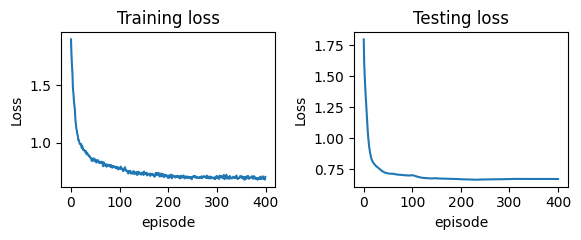

In [ ]:
fig=plt.figure(figsize=(6,2.5), dpi=100)

plt.subplot(1,2,1)
plt.plot(Loss_record)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Training loss')

plt.subplot(1,2,2)
plt.plot(Loss_record_test)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Testing loss')
fig.tight_layout()    

# Train - Trajectory Generation

## Hankel matrix

s [[ 0.01780478 -0.00614692 -0.01767937  0.0165402 ]]


Text(0, 0.5, 'V (p.u.)')

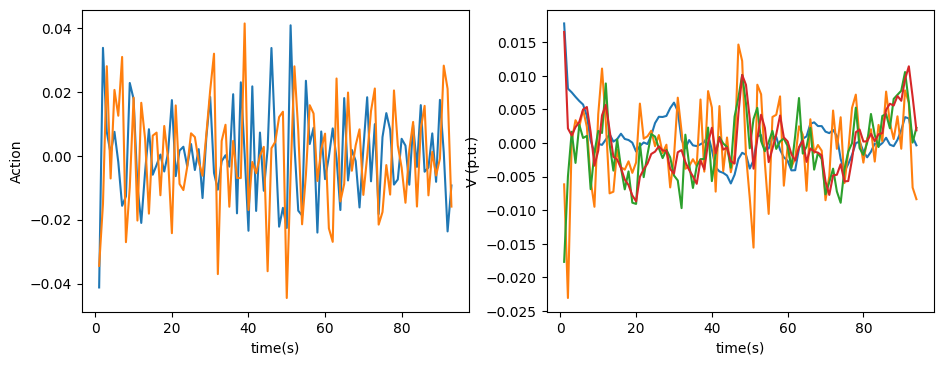

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[] 
Q_init_ratio = 0.7
P_init_ratio = 0.7
PredictLength = 30+0
sigma_e = 0.01

init_state=np.random.uniform(-0.02,0.02,(1, dim_state))
s=init_state.copy()
env.set_state(s)
SimulationLength=dim_state+PredictLength*(dim_action+1)-1
 
Record_u_Linear=[]
Record_q_Linear=[]
Trajectory_Linear.append(s@(Matrix_C.T))

Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
for i in range(SimulationLength):
    
    u=Action_linear(s,linear_coff,env) + np.random.normal(np.zeros((1,dim_action)), sigma_e)
    next_s= s@(Matrix_A.T) + u@(Matrix_B.T)
    s=next_s.copy()
    Trajectory_Linear.append(s@(Matrix_C.T))
    Record_u_Linear.append(np.squeeze(u))

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
plt.figure(figsize=(11,4), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord

plt.subplot(1,2,1)

plt.plot(TimeRecord,Record_u_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action')

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(1,2,2)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


In [ ]:
dim_state + PredictLength*dim_action

64

In [ ]:
HankelMatrix = np.zeros((PredictLength*dim_action+PredictLength*dim_observe, SimulationLength-PredictLength+1))
for i in range(SimulationLength-PredictLength+1):
    HankelMatrix[0:PredictLength*dim_action, i] = np.array(Record_u_Linear[i:i+PredictLength]).flatten()
    HankelMatrix[PredictLength*dim_action:PredictLength*dim_action+PredictLength*dim_observe, i] = \
          np.array(Trajectory_Linear[i:i+PredictLength]).flatten()
HankelMatrix_u = HankelMatrix[0:PredictLength*dim_action, :]
HankelMatrix_x = HankelMatrix[PredictLength*dim_action:PredictLength*dim_action+PredictLength*dim_observe, :]

In [ ]:
if np.linalg.matrix_rank(HankelMatrix) == dim_state + PredictLength*dim_action:
    print('rank condition holds')

rank condition holds


## train

In [ ]:
loop_seed = 1
PI_mono_list = []
loss_list = []
loss_list_test = []
computer_time_list = []
sigma_e_init = 0.005

Batch_num=1000
learning_rate_initial=0.05
decay_stage = 50
decay_rate = 0.5
for loop in range(loop_seed):
    # random.seed(datetime.now())
    start = time.time()
    mu = Linear(units, dim_action,env,Batch_num)
    mu.variables[0].assign(linear_coff0*0.6)
    Policy_gradient_calss=Policy_gradient(units,dim_action, env,Batch_num, Batch_num_test)

    Loss_record = []
    Loss_record_test = []
    Loss_record_test_std = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)

    global_step = tf.Variable(0, trainable=False)
    decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, decay_stage, decay_rate, staircase=True)
    optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)
    Policy_gradient_calss.sigma_e=0.3
    [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Test(T, initial_state_test, Noise_batch_test)
    Loss_record_test.append(sum(reward_record)/Batch_num_test)
    Loss_record_test_std.append(np.std(reward_record))
    for i in range(0,episodes):
        Policy_gradient_calss.sigma_e=sigma_e_init*np.exp(-i/100)
        initial_state = np.random.uniform(-Init_state_bound,Init_state_bound,(Batch_num, dim_state))

        Noise_batch = []
        for t in range(T):
            normal_dist = tfp.distributions.Normal(tf.zeros((Batch_num, dim_action),dtype=tf.float32), 
                                                        Policy_gradient_calss.sigma_e*tf.ones((tf.shape(initial_state)[0],1),dtype=tf.float32))
            Noise_batch.append(tf.squeeze(normal_dist.sample(1)))
        Noise_batch = np.array(Noise_batch, dtype=np.float32)
        Matrix_Generate_Noise = np.hstack((np.reshape(np.swapaxes(Noise_batch,0,1), (Batch_num, -1)), initial_state))
        diag_hat_k = mu.variables[0]
        for idx in range(PredictLength-1):
            diag_hat_k = scipy.linalg.block_diag(diag_hat_k, mu.variables[0])
        Matrix_Generate_R = HankelMatrix_u - diag_hat_k@ HankelMatrix_x
        HankelMatrix_x1 = HankelMatrix[PredictLength*dim_action:PredictLength*dim_action+dim_state, :]
        Matrix_Generate_G = np.vstack((Matrix_Generate_R,HankelMatrix_x1))
        Traj_Generate_g = Matrix_Generate_G.T@np.linalg.inv(Matrix_Generate_G@Matrix_Generate_G.T)@Matrix_Generate_Noise.T
        Trajectory_record = tf.constant(np.swapaxes(np.reshape(HankelMatrix_x@Traj_Generate_g,
                                                               (PredictLength,dim_state,Batch_num)),1,2),
                                        dtype=tf.float32)
        Action_record =  tf.constant(np.swapaxes(np.reshape(HankelMatrix_u@Traj_Generate_g,
                                                            (PredictLength,dim_action,Batch_num)),1,2),
                                     dtype=tf.float32)

        reward_record = (env.Penalty_action*K.sum(K.abs(Action_record),axis=(0,2)) \
                         + K.sum(K.abs(Trajectory_record),axis=(0,2)))
        loss=Policy_gradient_calss.Train(Trajectory_record,
                                         Action_record,
                                         reward_record)
        Loss_record.append(sum(reward_record)/Batch_num)

        if i % (PrintUpdate) == 0:
            print('episode',i,' batch_loss',Loss_record[-1])

        [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Test(T, initial_state_test, Noise_batch_test)
        Loss_record_test.append(sum(reward_record)/Batch_num_test)
        Loss_record_test_std.append(np.std(reward_record))

        if i % (PrintUpdate) == 0:
            print('        batch_loss_test',Loss_record_test[-1])


    end = time.time()
    print(end - start)   
    computer_time_list.append(end - start)
    loss_list.append(np.array(Loss_record)) 


episode 0  batch_loss tf.Tensor(1.9158044, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.5066837, shape=(), dtype=float32)
episode 1  batch_loss tf.Tensor(1.6900905, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.3955908, shape=(), dtype=float32)
episode 2  batch_loss tf.Tensor(1.567453, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.3238311, shape=(), dtype=float32)
episode 3  batch_loss tf.Tensor(1.491089, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.2594645, shape=(), dtype=float32)
episode 4  batch_loss tf.Tensor(1.4466081, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.1813824, shape=(), dtype=float32)
episode 5  batch_loss tf.Tensor(1.3509626, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.1106471, shape=(), dtype=float32)
episode 6  batch_loss tf.Tensor(1.3144119, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(1.0508069, shape=(), dtype=float32)
episode 7  batch_loss tf.Tensor(1.24

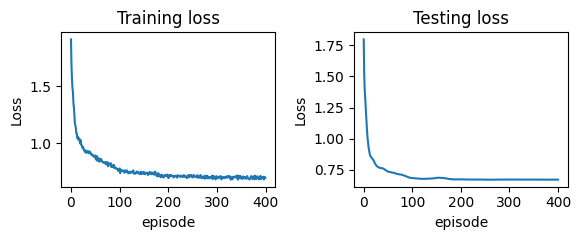

In [ ]:
fig=plt.figure(figsize=(6,2.5), dpi=100)

plt.subplot(1,2,1)
plt.plot(Loss_record)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Training loss')

plt.subplot(1,2,2)
plt.plot(Loss_record_test)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Testing loss')
fig.tight_layout()    

# Output feedback control

## Environment Setup

In [ ]:
dim_observe = 2
idx_observe = [0,1]
Matrix_C = np.zeros((dim_observe ,4))
for i in range(dim_observe ):
    Matrix_C[i, idx_observe[i]]=1
env = DynSystem(Matrix_A,Matrix_B, Matrix_C, dim_state,dim_action, dim_observe, Penalty_action)


## Hankel matrix full

Text(0, 0.5, 'V (p.u.)')

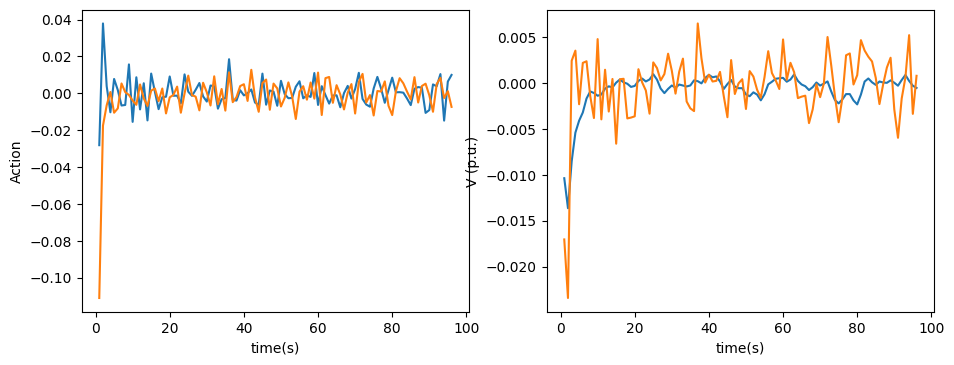

In [ ]:
Trajectory_Linear=[] 
PredictLength = 30+1
sigma_e = 0.005

init_state=np.random.uniform(-0.02,0.02,(1, dim_state))
s=init_state.copy()
env.set_state(s)
SimulationLength= dim_state+PredictLength*(dim_action+1)-1
 
Record_u_Linear=[]
Record_q_Linear=[]

Record_Loss_Linear=[]
Loss_Linear=0

for i in range(SimulationLength):

    observance = s@(Matrix_C.T)
    Trajectory_Linear.append(observance.copy())
    u=Action_linear(s,linear_coff,env) + np.random.normal(np.zeros((1,dim_action)), sigma_e)

    next_s= s@(Matrix_A.T) + u@(Matrix_B.T)

    s=next_s.copy()

    Record_u_Linear.append(np.squeeze(u))

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
plt.figure(figsize=(11,4), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord


plt.subplot(1,2,1)

plt.plot(TimeRecord,Record_u_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action')

TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(1,2,2)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


In [ ]:
SimulationLength

96

In [ ]:
HankelMatrix = np.zeros((PredictLength*dim_action+PredictLength*dim_observe, SimulationLength-PredictLength+1))
for i in range(SimulationLength-PredictLength+1):
    HankelMatrix[0:PredictLength*dim_action, i] = np.array(Record_u_Linear[i:i+PredictLength]).flatten()
    HankelMatrix[PredictLength*dim_action:PredictLength*dim_action+PredictLength*dim_observe, i] = \
          np.array(Trajectory_Linear[i:i+PredictLength]).flatten()
HankelMatrix_u = HankelMatrix[0:PredictLength*dim_action, :]
HankelMatrix_y = HankelMatrix[PredictLength*dim_action:PredictLength*dim_action+PredictLength*dim_observe, :]

In [ ]:
if np.linalg.matrix_rank(HankelMatrix) == dim_state + PredictLength*dim_action:
    print('rank condition holds')

rank condition holds


## train partial-Hankel

In [ ]:
linear_coff_y =0.6*linear_coff0@np.linalg.pinv(Matrix_C)

In [ ]:
np.absolute(np.linalg.eig(Matrix_A+Matrix_B@linear_coff_y@Matrix_C)[0])

array([0.8599522 , 0.8599522 , 0.79007526, 0.4365251 ])

In [ ]:
episodes =400 # total number of iterations to update weights
action_units=dim_action
units=action_units #dimension of each state
internal_units=20 # demension of the neural network for control policy
Init_state_bound = 0.1
T=30  #Total period considered
Batch_num=1000 # number of batch in each episodes

PrintUpdate = 1
Batch_num_test = 800
loop_seed = 1

PI_mono_list = []
loss_list = []
loss_list_test = []
computer_time_list = []
sigma_e_init = 0.01
units=action_units #dimension of each state

learning_rate_initial=0.05
decay_stage = 50
decay_rate = 0.5
T_init = 2
random.seed(1)
for loop in range(loop_seed):
    # random.seed(datetime.now())
    start = time.time()
    mu = Linear(units, dim_observe,env,Batch_num)
    mu.variables[0].assign(linear_coff_y)
    Policy_gradient_calss=Policy_gradient(units, dim_observe, env, Batch_num, Batch_num_test)

    Loss_record = []
    Loss_record_test = []
    Loss_record_test_std = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)

    global_step = tf.Variable(0, trainable=False)
    decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, decay_stage, decay_rate, staircase=True)
    optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)
    Policy_gradient_calss.sigma_e=0.3
    [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Test(T, initial_state_test, Noise_batch_test)
    Loss_record_test.append(sum(reward_record)/Batch_num_test)
    Loss_record_test_std.append(np.std(reward_record))
    for i in range(0,episodes):
        Policy_gradient_calss.sigma_e=sigma_e_init*np.exp(-i/100)
        init_state0 = np.random.uniform(-Init_state_bound,Init_state_bound,(Batch_num, dim_state))
        init_y0 = init_state0@(Matrix_C.T)
        init_u0 = init_y0@(linear_coff_y.T)
        init_state1 = init_state0@(Matrix_A.T) + init_u0@(Matrix_B.T)
        init_y1 = init_state1@(Matrix_C.T)

        Noise_batch = []
        for t in range(T):
            normal_dist = tfp.distributions.Normal(tf.zeros((Batch_num, dim_action),dtype=tf.float32), 
                                                        Policy_gradient_calss.sigma_e*tf.ones((tf.shape(init_state1)[0],1),dtype=tf.float32))
            Noise_batch.append(tf.squeeze(normal_dist.sample(1)))
        Noise_batch = np.array(Noise_batch, dtype=np.float32)
        Matrix_Generate_Noise = np.hstack((np.reshape(np.swapaxes(Noise_batch,0,1), (Batch_num, -1)), init_y0, init_y1, init_u0))
        diag_hat_k = mu.variables[0]
        for idx in range(T-1):
            diag_hat_k = scipy.linalg.block_diag(diag_hat_k, mu.variables[0])
        HankelMatrix_y_after = HankelMatrix[PredictLength*dim_action+dim_observe*(T_init-1):, :]
        HankelMatrix_u_after = HankelMatrix[dim_action*(T_init-1):PredictLength*dim_action, :]
        Matrix_Generate_R = HankelMatrix_u_after - diag_hat_k@ HankelMatrix_y_after

        HankelMatrix_yInit = HankelMatrix[PredictLength*dim_action:PredictLength*dim_action+dim_observe*T_init, :]
        HankelMatrix_uInit = HankelMatrix[0:dim_action*(T_init-1), :]

        Matrix_Generate_G = np.vstack((Matrix_Generate_R,HankelMatrix_yInit,HankelMatrix_uInit))
        Traj_Generate_g = Matrix_Generate_G.T@np.linalg.inv(Matrix_Generate_G@Matrix_Generate_G.T)@Matrix_Generate_Noise.T
        Trajectory_record = tf.constant(np.swapaxes(np.reshape(HankelMatrix_y_after@Traj_Generate_g,
                                                               (T,dim_observe,Batch_num)),1,2),
                                        dtype=tf.float32)
        Action_record =  tf.constant(np.swapaxes(np.reshape(HankelMatrix_u_after@Traj_Generate_g,
                                                            (T,dim_action,Batch_num)),1,2),
                                     dtype=tf.float32)

        reward_record = (env.Penalty_action*K.sum(K.abs(Action_record),axis=(0,2)) \
                         + K.sum(K.abs(Trajectory_record),axis=(0,2)))
        loss=Policy_gradient_calss.Train(Trajectory_record,
                                         Action_record,
                                         reward_record)
        Loss_record.append(sum(reward_record)/Batch_num)

        if i % (PrintUpdate) == 0:
            print('episode',i,' batch_loss',Loss_record[-1])


        [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Test(T, initial_state_test, Noise_batch_test)
        Loss_record_test.append(sum(reward_record)/Batch_num_test)
        Loss_record_test_std.append(np.std(reward_record))

        if i % (PrintUpdate) == 0:
            print('        batch_loss_test',Loss_record_test[-1])


    end = time.time()
    print(end - start)   
    computer_time_list.append(end - start)
    loss_list.append(np.array(Loss_record)) 


episode 0  batch_loss tf.Tensor(1.2445887, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.96778136, shape=(), dtype=float32)
episode 1  batch_loss tf.Tensor(1.1694272, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.89552194, shape=(), dtype=float32)
episode 2  batch_loss tf.Tensor(1.094559, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.8399618, shape=(), dtype=float32)
episode 3  batch_loss tf.Tensor(1.0354153, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.7983535, shape=(), dtype=float32)
episode 4  batch_loss tf.Tensor(0.9717337, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.7609288, shape=(), dtype=float32)
episode 5  batch_loss tf.Tensor(0.9318708, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.73265266, shape=(), dtype=float32)
episode 6  batch_loss tf.Tensor(0.89097625, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.706843, shape=(), dtype=float32)
episode 7  batch_loss tf.Tensor(

In [ ]:
[np.mean(np.array(Loss_record)[-20:-1]), np.mean(np.array(Loss_record_test)[-20:-1]), ]

[0.5568032, 0.5391627]

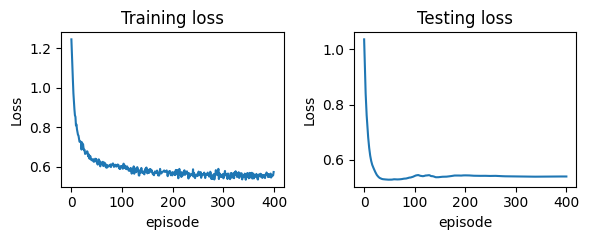

In [ ]:
fig=plt.figure(figsize=(6,2.5), dpi=100)

plt.subplot(1,2,1)
plt.plot(Loss_record)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Training loss')

plt.subplot(1,2,2)
plt.plot(Loss_record_test)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Testing loss')
fig.tight_layout()    

In [ ]:
mu.save_weights('/content/drive/MyDrive/Colab Notebooks/5. Decentralized_RL/Trajectory_generation/data/weights/partial_weights_AB_PG_Hankel')
# model.load_weights('/content/drive/MyDrive/Colab Notebooks/4. EIP Neurips/Power System/data/weights_RNN0513')


In [ ]:
f = open('/content/drive/MyDrive/Colab Notebooks/5. Decentralized_RL/Trajectory_generation/figure/partial_Loss_list_AB_PG_Hankel.pckl', 'wb')
pickle.dump([np.array(Loss_record), np.array(Loss_record_test), np.array(Loss_record_test_std)], f)
f.close()
# f = open('/content/drive/MyDrive/Colab Notebooks/4. EIP Neurips/Power System/data/Loss_record_Monon20_0513.pckl', 'rb')
# [Loss_record, Loss_record_test, Loss_record_test_std]= pickle.load(f)
# f.close()

## train partial-Real

In [ ]:
loop_seed = 1
PI_mono_list = []
loss_list = []
loss_list_test = []
computer_time_list = []

episodes =400 # total number of iterations to update weights
action_units=dim_action
units=action_units #dimension of each state
internal_units=20 # demension of the neural network for control policy
Init_state_bound = 0.1
T=30  #Total period considered
Batch_num=1000 # number of batch in each episodes

PrintUpdate = 1
Batch_num_test = 800
num_gen_step = 3
learning_rate_initial=0.05
decay_stage = 50
decay_rate = 0.5
random.seed(1)
for loop in range(loop_seed):
    # random.seed(datetime.now())
    start = time.time()
    mu = Linear(units, dim_observe,env,Batch_num)
    mu.variables[0].assign(linear_coff_y)

    Policy_gradient_calss=Policy_gradient(units,dim_observe, env, Batch_num, Batch_num_test)
    print(mu.variables[0])
    Loss_record = []
    Loss_record_test = []
    Loss_record_test_std = []
    Pe_rnn_record = []
    global_step = tf.Variable(0, trainable = False)
    decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate_initial, decay_stage, decay_rate, staircase=True)
    optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)
    Policy_gradient_calss.sigma_e=0.3
    [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Test(T, initial_state_test, Noise_batch_test)
    Loss_record_test.append(sum(reward_record)/Batch_num_test)
    Loss_record_test_std.append(np.std(reward_record))

    for i in range(0,episodes):
        Policy_gradient_calss.sigma_e=0.005*np.exp(-i/100)

        init_state0 = np.random.uniform(-Init_state_bound,Init_state_bound,(Batch_num, dim_state))
        init_y0 = init_state0@(Matrix_C.T)
        init_u0 = init_y0@(linear_coff_y.T)
        init_state1 = init_state0@(Matrix_A.T) + init_u0@(Matrix_B.T)
        Noise_batch = []
        for t in range(T):
            normal_dist = tfp.distributions.Normal(tf.zeros((Batch_num, dim_action),dtype=tf.float32), 
                                                        Policy_gradient_calss.sigma_e*tf.ones((tf.shape(init_state1)[0],1),dtype=tf.float32))
            Noise_batch.append(tf.squeeze(normal_dist.sample(1)))
        # [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Sample_One(T, initial_state, Noise_batch)
        [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Sample(T, init_state1, Noise_batch)
        loss=Policy_gradient_calss.Train(Trajectory_record,Action_record,reward_record)
        Loss_record.append(sum(reward_record)/Batch_num)

        if i % (PrintUpdate) == 0:
            print('episode',i,' batch_loss',Loss_record[-1])

        [Trajectory_record,Action_record,reward_record]=Policy_gradient_calss.Test(T, initial_state_test, Noise_batch_test)
        Loss_record_test.append(sum(reward_record)/Batch_num_test)
        Loss_record_test_std.append(np.std(reward_record))

        if i % (PrintUpdate) == 0:
            print('        batch_loss_test',Loss_record_test[-1])


    end = time.time()
    print(end - start)   
    computer_time_list.append(end - start)
    loss_list.append(np.array(Loss_record)) 


<tf.Variable 'k_node_p:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.03834, -0.42414],
       [ 1.28886,  0.0525 ]], dtype=float32)>
episode 0  batch_loss tf.Tensor(1.1519569, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.96570456, shape=(), dtype=float32)
episode 1  batch_loss tf.Tensor(1.085767, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.9227764, shape=(), dtype=float32)
episode 2  batch_loss tf.Tensor(0.9996519, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.8684299, shape=(), dtype=float32)
episode 3  batch_loss tf.Tensor(0.9968513, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.82020587, shape=(), dtype=float32)
episode 4  batch_loss tf.Tensor(0.9348607, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.78502256, shape=(), dtype=float32)
episode 5  batch_loss tf.Tensor(0.90317744, shape=(), dtype=float32)
        batch_loss_test tf.Tensor(0.7558065, shape=(), dtype=float32)
episode 6  batch_loss tf.Tensor(0

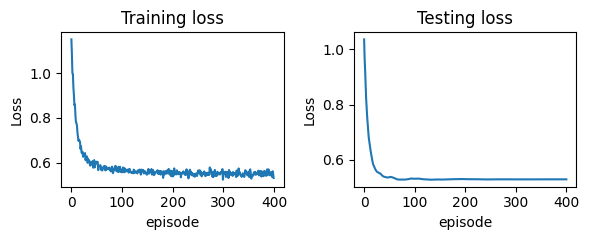

In [ ]:
fig=plt.figure(figsize=(6,2.5), dpi=100)

plt.subplot(1,2,1)
plt.plot(Loss_record)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Training loss')

plt.subplot(1,2,2)
plt.plot(Loss_record_test)
plt.xlabel('episode')
plt.ylabel('Loss')
plt.title('Testing loss')
fig.tight_layout()    